# Libs

In [ ]:
import numpy as np

# Tab Data
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

pd.set_option("display.float_format", lambda x: "%.5f" % x)

# Geo Data
import geopandas as gpd
from shapely.geometry import shape

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_white"

# Functions

## Data Processing

In [ ]:
def valid_vendor_payment_filter(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the input DataFrame to remove rows where vendor_id equals 6,
    payment_type equals 0, or the pickup and dropoff times are the same.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data to filter.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    return df.query(
        "vendor_id != 6 and payment_type != 0 and tpep_pickup_datetime != tpep_dropoff_datetime"
    )

In [ ]:
def quantile_filter(
    df: pd.DataFrame, cols: list[str], low: float, high: float
) -> pd.DataFrame:
    """
    Filters the input DataFrame by applying quantile-based thresholds to specified columns.

    Args:
        df (pd.DataFrame): The input DataFrame to filter.
        cols (list[str]): A list of column names to apply the quantile filtering.
        low (float): The lower quantile threshold (e.g., 0.05 for the 5th percentile).
        high (float): The upper quantile threshold (e.g., 0.95 for the 95th percentile).

    Returns:
        pd.DataFrame: The filtered DataFrame with rows within the specified quantile range for each column.
    """

    for col in cols:
        percentiles = df[col].quantile([low, high]).values
        df = df.query(f"({col} >= {percentiles[0]} and {col} <= {percentiles[1]})")
    return df

In [ ]:
def col_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' columns
    in the input DataFrame to datetime objects.

    Args:
        df (pd.DataFrame): The input DataFrame containing the datetime columns.

    Returns:
        pd.DataFrame: The DataFrame with the specified columns converted to datetime format.
    """

    return df.assign(
        tpep_pickup_datetime=pd.to_datetime(df["tpep_pickup_datetime"]),
        tpep_dropoff_datetime=pd.to_datetime(df["tpep_dropoff_datetime"]),
    )

In [ ]:
def get_us_holidays(year: int) -> pd.DatetimeIndex:
    """
    Retrieves the US federal holidays for a specified year.

    Args:
        year (int): The year for which to retrieve the US federal holidays.

    Returns:
        pd.DatetimeIndex: A DatetimeIndex object containing the dates of the US federal holidays.
    """

    us_hollydays = USFederalHolidayCalendar().holidays(
        start=f"{year}-01-01", end=f"{year}-12-31"
    )
    us_hollydays = pd.to_datetime(us_hollydays).date
    return us_hollydays

In [ ]:
def valid_trip_filter(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Filters the input DataFrame by removing rows where any of the specified columns have non-positive values.

    Args:
        df (pd.DataFrame): The input DataFrame containing trip data.
        cols (list[str]): A list of column names that should contain positive values.

    Returns:
        pd.DataFrame: The filtered DataFrame where all specified columns have values greater than 0.
    """

    validation_trip_query = " and ".join([f"{col} > 0" for col in cols])
    return df.query(validation_trip_query)

In [ ]:
def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing values in the input DataFrame by filling specific columns with default values or the mean.

    - 'passenger_count' is filled with the mean value (converted to an integer).
    - 'ratecode_id', 'congestion_surcharge', and 'airport_fee' are filled with 0.

    Args:
        df (pd.DataFrame): The input DataFrame with missing values.

    Returns:
        pd.DataFrame: The DataFrame with missing values imputed.
    """

    return df.assign(
        passenger_count=df["passenger_count"].fillna(
            value=int(df["passenger_count"].mean())
        ),
        ratecode_id=df["ratecode_id"].fillna(value=0),
        congestion_surcharge=df["congestion_surcharge"].fillna(value=0),
        airport_fee=df["airport_fee"].fillna(value=0),
    )

## Additional Features

In [ ]:
def calculate_time_features(
    df: pd.DataFrame, us_holidays: pd.DatetimeIndex
) -> pd.DataFrame:
    """
    Calculates various time-based features for each trip in the input DataFrame, including:

    - 'tpep_pickup_date': The pickup date.
    - 'tpep_pickup_month': The month of pickup.
    - 'tpep_pickup_hour': The hour of pickup.
    - 'tpep_dropoff_hour': The hour of dropoff.
    - 'tpep_pickup_day': The day of the pickup.
    - 'tpep_pickup_weekday': The day of the week for pickup.
    - 'tpep_dropoff_weekday': The day of the week for dropoff.
    - 'trip_duration_s': Trip duration in seconds.
    - 'trip_duration_m': Trip duration in minutes.
    - 'trip_duration_h': Trip duration in hours.
    - 'holiday': Whether the pickup date falls on a US federal holiday.

    Args:
        df (pd.DataFrame): The input DataFrame containing trip data.
        us_holidays (pd.DatetimeIndex): A DatetimeIndex object containing the dates of US federal holidays.

    Returns:
        pd.DataFrame: The DataFrame with the newly calculated time features.
    """

    return df.assign(
        tpep_pickup_date=lambda x: x["tpep_pickup_datetime"].dt.date,
        tpep_pickup_month=df["tpep_pickup_datetime"].dt.month,
        tpep_pickup_hour=df["tpep_pickup_datetime"].dt.hour,
        tpep_dropoff_hour=df["tpep_dropoff_datetime"].dt.hour,
        tpep_pickup_day=df["tpep_pickup_datetime"].dt.day,
        tpep_pickup_weekday=df["tpep_pickup_datetime"].dt.weekday,
        tpep_dropoff_weekday=df["tpep_dropoff_datetime"].dt.weekday,
        trip_duration_s=(
            df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
        ).dt.total_seconds(),
        trip_duration_m=(
            df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
        ).dt.total_seconds()
        / 60,
        trip_duration_h=(
            df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
        ).dt.total_seconds()
        / 3600,
        holiday=lambda x: x["tpep_pickup_date"].isin(us_holidays),
    )

In [ ]:
def calculate_trip_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates various trip features for the input DataFrame, including:

    - 'trip_distance_mi': The distance of the trip in miles.
    - 'trip_distance_km': The distance of the trip in kilometers.
    - 'speed_mph': The average speed of the trip in miles per hour.
    - 'speed_kmh': The average speed of the trip in kilometers per hour.
    - 'tips_per_min': The average tip amount per minute of the trip.

    The function replaces infinite values with NaN.

    Args:
        df (pd.DataFrame): The input DataFrame containing trip data.

    Returns:
        pd.DataFrame: The DataFrame with the newly calculated trip features.
    """
    return df.assign(
        trip_distance_mi=lambda x: x["trip_distance"],
        trip_distance_km=lambda x: x["trip_distance"] * 1.609,
        speed_mph=lambda x: x["trip_distance_mi"] / x["trip_duration_h"],
        speed_kmh=lambda x: x["trip_distance_km"] / x["trip_duration_h"],
        tips_per_min=lambda x: x["tip_amount"] / x["trip_duration_m"],
    ).replace([np.inf, -np.inf], np.nan)

# Data

In [ ]:
df = pd.read_csv(
    "./data/yellow_taxi_trip_records_2023.csv",
)

<ipython-input-11-976cf4621e8a>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [ ]:
df = df.pipe(col_to_datetime)

# EDA

## General

### Normalize column names

In [ ]:
df = df.rename(
    columns={
        "VendorID": "vendor_id",
        "RatecodeID": "ratecode_id",
        "PULocationID": "pu_location_id",
        "DOLocationID": "do_location_id",
    }
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9102346 entries, 0 to 9102345
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   vendor_id              int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   ratecode_id            float64       
 6   store_and_fwd_flag     object        
 7   pu_location_id         int64         
 8   do_location_id         int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

## Missing values

In [ ]:
df.isnull().sum().reset_index().rename(columns={0: "missing"}).query("missing > 0")

index  missing
3        passenger_count   310802
5            ratecode_id   310802
6     store_and_fwd_flag   310802
17  congestion_surcharge   310802
18           airport_fee   310802

In [ ]:
df.query(
    "passenger_count.isnull()", engine="python"
).isnull().sum().reset_index().rename(columns={0: "missing"}).query("missing > 0")

index  missing
3        passenger_count   310802
5            ratecode_id   310802
6     store_and_fwd_flag   310802
17  congestion_surcharge   310802
18           airport_fee   310802

Here we can see that all columns that have missing values have the same number of them and the same columns are missing for all, this might indicate a systematic error in the data collection process.


Imputation strategy:
- **passenger_count**: fill with mean (We assume that the passenger count its similar for all trips)
- **ratecode_id**: fill with 0 (Not enough context to confidently assign a value)
- **store_and_fwd_flag**: drop column (We assume that this feature is not relevant for the current analysis because it's more related to the connectivity of the unit than to the trip.)
- **congestion_surcharge**: fill with 0 (Not enough context to confidently assign a value)
- **airport_fee**: fill with 0 (Not enough context to confidently assign a value, we could assign the fee if the destination it's LaGuardia and John F. Kennedy Airports but because we can’t know if the RatecodeID was ‘Negotiated fare’ or some other case)


### Vendors

From the 'data_dictionary_trip_records_yellow' we expect to have only vendor 1 and 2. So we can assume that vendor 6 is a data collection error and remove the rows from the data set.


In [ ]:
df.vendor_id.value_counts(normalize=True)

vendor_id
2   0.73769
1   0.26208
6   0.00023
Name: proportion, dtype: float64

### payment_type

There is no payment_type 0 in data_dictionary_trip_records_yellow so we can assume it's an erroneous entry and delete them.

In [ ]:
df.payment_type.unique()

array([1, 2, 4, 3, 0, 5])

## Trip time

In some cases the pickup time at dropoff time is the same. So we will consider them as invalid trips.

In [ ]:
df.query("tpep_pickup_datetime == tpep_dropoff_datetime").head()

vendor_id tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1199           1  2023-01-01 01:54:01   2023-01-01 01:54:01          1.00000   
6899           1  2023-01-01 11:54:51   2023-01-01 11:54:51          1.00000   
8642           1  2023-01-01 13:48:03   2023-01-01 13:48:03          2.00000   
9568           2  2023-01-01 14:34:19   2023-01-01 14:34:19          3.00000   
10456          1  2023-01-01 15:10:17   2023-01-01 15:10:17          1.00000   

       trip_distance  ratecode_id store_and_fwd_flag  pu_location_id  \
1199         0.00000      1.00000                  N             237   
6899         0.00000      1.00000                  N             230   
8642         0.00000      2.00000                  N             132   
9568         0.00000      5.00000                  N             264   
10456        0.00000      1.00000                  N             239   

       do_location_id  payment_type  fare_amount   extra  mta_tax  tip_amount  \
1199              264             2      3.00000 3.50000  0.50000     0.00000   
6899              264             2      3.00000 2.50000  0.50000     0.00000   
8642              264             2     70.00000 2.50000  0.50000     0.00000   
9568              264             1     60.00000 0.00000  0.00000     0.00000   
10456             264             2      3.00000 2.50000  0.50000     0.00000   

       tolls_amount  improvement_surcharge  total_amount  \
1199        0.00000                1.00000       8.00000   
6899        0.00000                1.00000       7.00000   
8642        6.55000                1.00000      80.55000   
9568        0.00000                0.00000      60.00000   
10456       0.00000                1.00000       7.00000   

       congestion_surcharge  airport_fee  
1199                2.50000      0.00000  
6899                2.50000      0.00000  
8642                2.50000      1.25000  
9568                0.00000      0.00000  
10456               2.50000      0.00000

## Negative values

In [ ]:
trip_features = [
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
]

In [ ]:
df.describe()

vendor_id           tpep_pickup_datetime  \
count 9102346.00000                        9102346   
mean        1.73885  2023-07-02 22:44:36.208844288   
min         1.00000            2001-01-01 00:07:36   
25%         1.00000  2023-04-02 18:36:26.249999872   
50%         2.00000            2023-06-27 18:51:41   
75%         2.00000  2023-10-06 22:11:43.750000128   
max         6.00000            2024-01-03 19:42:57   
std         0.44450                            NaN   

               tpep_dropoff_datetime  passenger_count  trip_distance  \
count                        9102346    8791544.00000  9102346.00000   
mean   2023-07-02 22:58:56.816763392          1.37052        4.07246   
min              1970-01-20 10:16:32          0.00000        0.00000   
25%    2023-04-02 18:54:02.249999872          1.00000        1.04000   
50%              2023-06-27 19:06:16          1.00000        1.79000   
75%              2023-10-06 22:27:46          1.00000        3.40000   
max              2024-01-03 20:15:55          9.00000   265869.44000   
std                              NaN          0.89262      239.69896   

        ratecode_id  pu_location_id  do_location_id  payment_type  \
count 8791544.00000   9102346.00000   9102346.00000 9102346.00000   
mean        1.63873       165.20112       163.92709       1.18484   
min         1.00000         1.00000         1.00000       0.00000   
25%         1.00000       132.00000       113.00000       1.00000   
50%         1.00000       162.00000       162.00000       1.00000   
75%         1.00000       234.00000       234.00000       1.00000   
max        99.00000       265.00000       265.00000       5.00000   
std         7.40553        63.96082        69.86483       0.55630   

        fare_amount         extra       mta_tax    tip_amount  tolls_amount  \
count 9102346.00000 9102346.00000 9102346.00000 9102346.00000 9102346.00000   
mean       19.52510       1.55733       0.48560       3.52076       0.58954   
min     -1087.30000      -7.50000      -0.50000    -100.01000     -77.75000   
25%         9.30000       0.00000       0.50000       1.00000       0.00000   
50%        13.50000       1.00000       0.50000       2.80000       0.00000   
75%        21.90000       2.50000       0.50000       4.41000       0.00000   
max    187502.96000   10002.50000       4.00000     350.00000     177.00000   
std        65.26248       3.79234       0.10858       4.06691       2.19813   

       improvement_surcharge  total_amount  congestion_surcharge   airport_fee  
count          9102346.00000 9102346.00000         8791544.00000 8791544.00000  
mean                 0.97943      28.46407               2.26468       0.14002  
min                 -1.00000   -1094.05000              -2.50000      -1.75000  
25%                  1.00000      15.95000               2.50000       0.00000  
50%                  1.00000      21.00000               2.50000       0.00000  
75%                  1.00000      30.72000               2.50000       0.00000  
max                  1.00000  187513.90000               2.75000       1.75000  
std                  0.19925      67.18007               0.79698       0.46862

Here we can see that there are some trips with distance and passenger_count 0, this is not a valid trip so will remove them.
We also notice that the features associated with payments have negative values, it makes no sense that the taxi driver is paying the customer, so we will also remove them.

We can define a valid trip as: passenger_count > 0 and trip_distance > 0 and fare_amount > 0 and tip_amount > 0


In [ ]:
temp_df = valid_trip_filter(df, trip_features)
temp_df.describe()

vendor_id           tpep_pickup_datetime  \
count 6614275.00000                        6614275   
mean        1.75944  2023-07-02 00:02:31.563316480   
min         1.00000            2003-01-01 00:03:31   
25%         2.00000            2023-04-01 12:22:12   
50%         2.00000            2023-06-25 16:30:39   
75%         2.00000            2023-10-06 20:38:50   
max         2.00000            2024-01-03 19:42:57   
std         0.42742                            NaN   

               tpep_dropoff_datetime  passenger_count  trip_distance  \
count                        6614275    6614275.00000  6614275.00000   
mean   2023-07-02 00:19:28.637754624          1.37667        3.53022   
min              2003-01-01 14:54:12          1.00000        0.01000   
25%       2023-04-01 12:36:22.500000          1.00000        1.10000   
50%              2023-06-25 16:50:20          1.00000        1.81000   
75%              2023-10-06 20:55:23          1.00000        3.36000   
max              2024-01-03 20:15:55          9.00000   161726.10000   
std                              NaN          0.86999       67.68459   

        ratecode_id  pu_location_id  do_location_id  payment_type  \
count 6614275.00000   6614275.00000   6614275.00000 6614275.00000   
mean        1.05887       166.69068       165.81427       1.00006   
min         1.00000         1.00000         1.00000       1.00000   
25%         1.00000       132.00000       114.00000       1.00000   
50%         1.00000       162.00000       162.00000       1.00000   
75%         1.00000       234.00000       236.00000       1.00000   
max        99.00000       265.00000       265.00000       4.00000   
std         0.32428        63.29057        69.26348       0.01224   

        fare_amount         extra       mta_tax    tip_amount  tolls_amount  \
count 6614275.00000 6614275.00000 6614275.00000 6614275.00000 6614275.00000   
mean       19.44360       1.64905       0.49711       4.60040       0.59814   
min         0.01000       0.00000       0.00000       0.01000       0.00000   
25%         9.30000       0.00000       0.50000       2.40000       0.00000   
50%        13.50000       1.00000       0.50000       3.42000       0.00000   
75%        21.20000       2.50000       0.50000       5.00000       0.00000   
max       999.00000      14.25000       4.00000     350.00000      96.94000   
std        17.28347       1.84148       0.03803       4.01041       2.14906   

       improvement_surcharge  total_amount  congestion_surcharge   airport_fee  
count          6614275.00000 6614275.00000         6614275.00000 6614275.00000  
mean                 0.99971      29.69553               2.37268       0.13495  
min                  0.00000       1.09000               0.00000       0.00000  
25%                  1.00000      16.80000               2.50000       0.00000  
50%                  1.00000      21.84000               2.50000       0.00000  
75%                  1.00000      31.40000               2.50000       0.00000  
max                  1.00000    1239.95000               2.75000       1.75000  
std                  0.01433      22.81175               0.54962       0.45297

## Quantile Filtering

In [ ]:
temp_df[trip_features].describe()

passenger_count  trip_distance   fare_amount    tip_amount
count    6614275.00000  6614275.00000 6614275.00000 6614275.00000
mean           1.37667        3.53022      19.44360       4.60040
std            0.86999       67.68459      17.28347       4.01041
min            1.00000        0.01000       0.01000       0.01000
25%            1.00000        1.10000       9.30000       2.40000
50%            1.00000        1.81000      13.50000       3.42000
75%            1.00000        3.36000      21.20000       5.00000
max            9.00000   161726.10000     999.00000     350.00000

We can notice that for the trip features the maximum value its orders of magnitude greater than the mean and std. So we filter by the 98% quantile.

In [ ]:
quantile_filter(temp_df, trip_features, low=0.01, high=0.98)[trip_features].describe()

passenger_count  trip_distance   fare_amount    tip_amount
count    6125542.00000  6125542.00000 6125542.00000 6125542.00000
mean           1.32900        2.80994      17.09917       4.08203
std            0.75206        2.97914      11.98389       2.66344
min            1.00000        0.35000       5.10000       1.00000
25%            1.00000        1.10000       9.30000       2.42000
50%            1.00000        1.78000      13.50000       3.36000
75%            1.00000        3.07000      19.80000       4.90000
max            5.00000       18.60000      70.00000      15.84000

<Axes: >

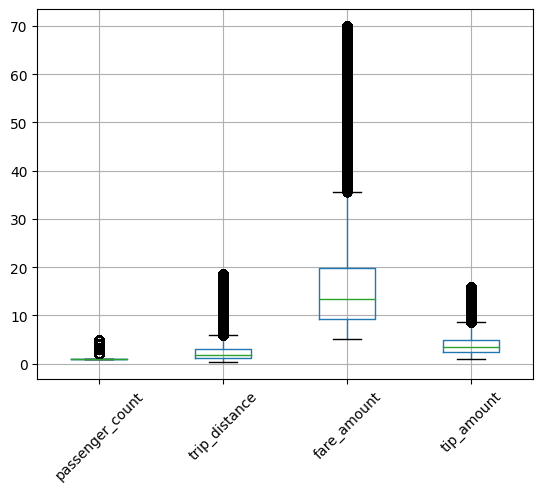

In [ ]:
quantile_filter(temp_df, trip_features, low=0.01, high=0.98).boxplot(
    trip_features, rot=45
)

# Cleaning

Putting all the steps together we can construct the following pipeline.



In [ ]:
trip_features = [
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
]

drop_features = ["store_and_fwd_flag"]

LOW_QUANTILE = 0.01
HIGH_QUANTILE = 0.95

In [ ]:
df = (
    df.drop(columns=drop_features)
    .pipe(valid_vendor_payment_filter)
    .pipe(valid_trip_filter, cols=trip_features)
    .pipe(quantile_filter, cols=trip_features, low=LOW_QUANTILE, high=HIGH_QUANTILE)
    .pipe(impute_missing)
)

# Additional Features

With the information we have we can create some new features, there are 2 groups of features will be adding:
1. Time bared, this are features like month, weekday, hour, trip duration, holydays, etc.
2. Trip based, this are features like distance and speed.

In [ ]:
us_holidays = get_us_holidays(2023)

In [ ]:
df = df.pipe(calculate_time_features, us_holidays).pipe(calculate_trip_features)

# Geo Data

In [ ]:
def preprocess_geo_data(geo_df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses geographic data by sorting based on area, removing duplicates, calculating area in square miles,
    and adding centroid information.

    Args:
        geo_df (pd.DataFrame): The input DataFrame containing geographic data with 'LocationID' and 'geometry' columns.

    Returns:
        pd.DataFrame: The processed DataFrame with calculated area in square miles and centroid information.
    """

    geo_df = geo_df.sort_values("area_mi2", ascending=False).drop_duplicates(
        "LocationID", keep="first"
    )
    geo_df["area_mi2"] = geo_df.geometry.apply(lambda x: shape(x).area / 2.788e7)

    geo_df["centroid"] = geo_df.centroid

    return geo_df

In [ ]:
def get_geo_maps(geo_df: pd.DataFrame) -> tuple[dict[int, str], dict[int, float]]:
    """
    Creates mappings for boroughs and areas from geographic data based on 'LocationID'.

    Args:
        geo_df (pd.DataFrame): The input DataFrame containing geographic data with 'LocationID', 'borough', and 'area_mi2' columns.

    Returns:
        tuple[dict[int, str], dict[int, float]]:
            - A dictionary mapping 'LocationID' to borough names.
            - A dictionary mapping 'LocationID' to the area in square miles, with a fixed value for location 264.
    """
    borough_map = geo_df.set_index("LocationID")["borough"].to_dict()
    area_map = geo_df.set_index("LocationID")["area_mi2"].to_dict()
    area_map[264] = 0  # Fix missing value
    return borough_map, area_map

In [ ]:
geo_df = gpd.read_file("./data/taxi_zones_shapefile/taxi_zones.shp")

We have 265 values in the taxi zones lookup table, so we are missing the geo data for 5 of them. This also indicates that there are duplicate values for some of the LocationID.

In [ ]:
geo_df.LocationID.unique().size

260

In [ ]:
geo_df.LocationID.value_counts().head(2)

LocationID
103    3
56     2
Name: count, dtype: int64

## Additional Features

Using geopandas integrated functions we can also calculate the area and the centroids of all the shapes.

In [ ]:
geo_df["area_mi2"] = geo_df.geometry.apply(lambda x: shape(x).area / 2.788e7)
geo_df["area_mi2"]

0     2.83499
1     5.16175
2     1.13648
3     0.28780
4     1.80828
        ...  
258   1.42544
259   1.52934
260   0.12442
261   0.24956
262   0.23803
Name: area_mi2, Length: 263, dtype: float64

In [ ]:
geo_df.centroid

0        POINT (935996.821 191376.75)
1      POINT (1031085.719 164018.754)
2      POINT (1026452.617 254265.479)
3       POINT (990633.981 202959.782)
4        POINT (931871.37 140681.351)
                    ...              
258    POINT (1025106.231 266453.415)
259    POINT (1010211.977 210434.892)
260     POINT (980639.512 197635.174)
261     POINT (999064.725 221974.401)
262      POINT (997817.92 223005.988)
Length: 263, dtype: geometry

Lastly we can construct a set of dictionaries that will allow us to easily map data to the main dataframe.

In [ ]:
borough_map = geo_df.set_index("LocationID")["borough"].to_dict()

In [ ]:
area_map = geo_df.set_index("LocationID")["area_mi2"].to_dict()